In [1]:
import os
import sys
import pickle
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve
from typing import Dict, Optional

sys.path.insert(0, '..')
sys.path.insert(0, '../..')
sys.path.insert(0, '../../..')
sys.path.insert(0, '../../../..')
sys.path.insert(0, '../../../../..')

from deviation_prediction.deviation import Deviation
from evaluation.deviations_evalaution_metrics import EvaluationMetrics

## Load Thresholds and Conformal Prediction Sets

In [2]:
# Load results form Conformal Analysis .pkl file
output_dir = '../../../../../../data/Helpdesk/conformal_val/conformal_conformance_results'

filename = os.path.join(output_dir, 'results.pkl')
with open(filename, 'rb') as f:
    loaded_conformal_results = pickle.load(f)
print(f"Loaded data from {filename}")

# Data loaded:
alpha_low_risk, alpha_risk, alpha_high_risk = loaded_conformal_results["alphas"]

# dict: prefix length, r: sampled fitness score threshold lower bound with 1-alpha coverage.
q_samples_per_prefix_length = loaded_conformal_results["q_samples_per_prefix_length"]

# dict: prefix length, r: sampled fitness score threshold lower bound with 1-alpha coverage.
r_samples_per_prefix_length = loaded_conformal_results["r_samples_per_prefix_length"]

# dict: prefix length, r: sampled fitness score threshold lower bound with 1-alpha coverage.
z_samples_per_prefix_length = loaded_conformal_results["z_samples_per_prefix_length"]

Loaded data from ../../../../../../data/Helpdesk/conformal_val/conformal_conformance_results/results.pkl


In [3]:
# Get Dict with prefix length and threshold values
q_fitness_prefix_lens = {}
r_fitness_prefix_lens = {}
z_fitness_prefix_lens = {}

for prefix_length in q_samples_per_prefix_length.keys():
    # Low-Risk Threshold:
    q_fitness_samples = q_samples_per_prefix_length[prefix_length]
    q_fitness_prefix_lens[prefix_length] = q_fitness_samples
    # Risk Threshold:
    r_fitness_samples = r_samples_per_prefix_length[prefix_length]
    r_fitness_prefix_lens[prefix_length] = r_fitness_samples
    # High-Risk Threshold:
    z_fitness_samples = z_samples_per_prefix_length[prefix_length]
    z_fitness_prefix_lens[prefix_length] = z_fitness_samples

In [4]:
# Get results from the processed inference/ test dataset storing two dicts: 
output_dir   = '../../../../../../data/Helpdesk/conformal_prediction_gn_l4'

# Ensure the directory exists
os.makedirs(output_dir, exist_ok=True)

filename = os.path.join(output_dir, 'all_set.pkl')
with open(filename, 'rb') as f:
    results_all = pickle.load(f)
print(f"Loaded data from {filename}")

filename = os.path.join(output_dir, 'low_risk_set.pkl')
with open(filename, 'rb') as f:
    results_low_risk = pickle.load(f)
print(f"Loaded data from {filename}")

filename = os.path.join(output_dir, 'risk_set.pkl')
with open(filename, 'rb') as f:
    results_risk = pickle.load(f)
print(f"Loaded data from {filename}")

filename = os.path.join(output_dir, 'high_risk_set.pkl')
with open(filename, 'rb') as f:
    results_high_risk = pickle.load(f)
print(f"Loaded data from {filename}")

Loaded data from ../../../../../../data/Helpdesk/conformal_prediction_gn_l4/all_set.pkl
Loaded data from ../../../../../../data/Helpdesk/conformal_prediction_gn_l4/low_risk_set.pkl
Loaded data from ../../../../../../data/Helpdesk/conformal_prediction_gn_l4/risk_set.pkl
Loaded data from ../../../../../../data/Helpdesk/conformal_prediction_gn_l4/high_risk_set.pkl


## Mean, Standard Deviation, and Threshold Fitness Scores

In [5]:
def visualize_thresholds_fitness_distribution(result_set: Dict,
                                              alpha: Optional[float]=1.0,
                                              thresholds: Optional[Dict]={},):

    # grab the list of all metric‐names from the first entry
    fields = list(result_set[next(iter(result_set))].keys())
    # build the “pivoted” dict of dicts
    seperate_dict= {field: { prefix: subdict[field] for prefix, subdict in result_set.items() } for field in fields} 
    
    mean_samples_fitness = seperate_dict['mean_samples_fitness']
    sd_samples_fitness = seperate_dict['sd_samples_fitness']   
    
    # Sort by prefix length
    prefix = np.array([pl for pl in mean_samples_fitness.keys()])
    
    means  = np.array([np.mean(means) for means in mean_samples_fitness.values()])
    # print("Means: ", means)

    sds    = np.array([np.mean(sds) for sds in sd_samples_fitness.values()])
    # print("SDs: ", sds)

    uncertainties = np.array([sd/mean *100 for mean, sd in zip(means, sds)])
    # print("Uncertainties: ", uncertainties)

    certainty = np.array([100-(sd/mean*100) for mean, sd in zip(means, sds)])
    # print("Certainties: ", certainty)

    # 90% CI using z ≈ 1.645
    z90 = 1.645

    # Std within (fitness scores of T MC-Samples)-band: Probabilistic Suffix Prediction Fitness Score standard deviation:
    lower_psp = means - z90 * sds
    upper_psp = means + z90* sds

    plt.figure()
    plt.subplots(1, figsize=(12, 5))
    plt.plot(prefix, means, marker='o', label='Mean Means Samples', color='C0')

    if alpha < 1.0:
        threshs = np.array([t for pl, t in thresholds.items() if pl in result_set.keys()])
        print("Thresholds: ", threshs)
        label_thresh = 'Thresholds (Risk: alpha = ' + str(float(alpha)) + ')'
        plt.plot(prefix, threshs, marker='o', label=label_thresh, color='red')
    
    plt.fill_between(prefix, lower_psp, upper_psp, alpha=0.3, color='C1', label='Predictive Total Uncertainty')
    
    plt.xlabel('Prefix Length')
    plt.ylabel('Mean Metric')
    plt.title('Mean Curve with ±90% Confidence Interval (Risk: alpha = ' + str(float(alpha)) + ')')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

## Individual Divation Prediction Evaluation

In [6]:
def get_idp(result_set: Dict, beta_acceptance_rate: float):
    dev_obj = Deviation()
    
    # grab the list of all metric‐names from the first entry
    fields = list(result_set[next(iter(result_set))].keys())
    # build the “pivoted” dict of dicts
    seperate_dict= {field: { prefix: subdict[field] for prefix, subdict in result_set.items() } for field in fields} 

    target_conformance = seperate_dict['target_conformance']
    most_likely_conformance = seperate_dict['most_likely_conformance']
    
    # dict: prefix_length: list of list where mean fitness score smaller than threshold: 1000 MC samples with: 'sampled case', 'alignment', 'cost', 'fitness' 
    samples_conformance = seperate_dict['samples_conformance']
    
    deviations_target = dev_obj.individual_deviations_target(target_conformance=target_conformance)
    
    deviations_most_likely = dev_obj.individual_deviations_most_likely(most_likely_conformance=most_likely_conformance)
    
    deviations_samples = dev_obj.individual_deviations_samples(samples_conformance=samples_conformance, beta_threshold=beta_acceptance_rate)
    
    deviations_samples_prob = dev_obj.individual_deviations_samples(samples_conformance=samples_conformance, beta_threshold=beta_acceptance_rate, probabilistic=True)
    
    return deviations_target, deviations_most_likely, deviations_samples, deviations_samples_prob
    

In [7]:
def visualization_precision_recall(eval_obj: EvaluationMetrics):
    #  Measures how often the model is correct when it predicts a deviation.
    precision_dev, _ = eval_obj.precision_deviation()

    # This measures the model's ability to detect deviations when they actually occur. -> Models prediction in relation to deviations it does not predict
    recall_dev, _ = eval_obj.recall_deviation()
    
    prefix = np.array(list(precision_dev.keys()))
    prec = np.array(list(precision_dev.values()))
    rec = np.array(list(recall_dev.values()))

    _, (ax1) = plt.subplots(1, figsize=(12, 5))

    # Precision vs Recall vs Prefix
    ax1.plot(prefix, prec, marker='o')
    ax1.plot(prefix, rec, marker='s')
    ax1.set_xlabel('Prefix Length')
    ax1.set_ylabel('Score')
    ax1.set_title('Individual Deviation Prediction: Precision and Recall vs Prefix Length')
    ax1.legend(['Precision', 'Recall'])
    ax1.grid(True)

    plt.tight_layout()
    plt.show()

In [8]:
from sklearn.metrics import roc_curve, auc

def visualization_roc_curve_prob(eval_obj_prob: EvaluationMetrics):
    fpr_dict, tpr_dict, thr_dict, auc_macro, Y_true, Y_score, all_classes = eval_obj_prob.probabilistic_roc_deviation_multilabel(average='macro')
    
    plt.figure(figsize=(12, 5))
    
    plt.plot([0, 1], [0, 1], '--', label='Chance (AUC = 0.5)')
    
    fpr_micro, tpr_micro, _ = roc_curve(y_true=Y_true.ravel(), y_score=Y_score.ravel())
    
    plt.plot(fpr_micro, tpr_micro, marker='.', label=f'Average Macro ROC (AUC = {auc_macro:.3f})')

    # per-class in original class order
    for cls in fpr_dict:
        plt.plot(fpr_dict[cls], tpr_dict[cls], lw=1, alpha=0.7, label=f'{cls} (AUC={auc(fpr_dict[cls], tpr_dict[cls]):.2f})')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multi-Label ROC Curves')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
def visualization_class_coverage(eval_obj: EvaluationMetrics, target_all: dict, target_risk: dict):
        """
        1) Prints classes + coverage loss
        2) Bar + pie chart of presence
        3) Bar chart of % frequency in risk set
        """
        # compute coverage info
        # Classes all: All deviation classes in target
        # Presence: Are the clases detected in the prediction
        # loss: mean value of undetection related to detection
        classes_tgt, classes_prob_tgt, classes_unseen, classes_prob_unseen = eval_obj.compute_class_coverage(target_all, target_risk)
    
        if classes_tgt:
            plt.figure(figsize=(10, 6))  # taller figure
            # x positions for bars
            x = np.arange(len(classes_tgt))
            # plot bars
            _ = plt.bar(x, classes_prob_tgt*100, color='C0')
            # label x-axis
            plt.xticks(x, classes_tgt, rotation=90)
            # y-axis formatting
            plt.ylim(0, 100)
            plt.ylabel('% of  occurrences across all samples')
            plt.title('Deviation classes: In the targets and predicted.', pad=20)
            plt.grid(axis='y', linestyle='--', alpha=0.5)
            # annotate bars
            for xi, pct in zip(x, classes_prob_tgt*100):
                if pct > 0:
                    plt.text(xi, pct + 2, f'{pct:.0f}%', ha='center', va='bottom', fontsize=8)

            plt.tight_layout()
            plt.show()
        
        if classes_unseen:
            plt.figure(figsize=(10, 6))  # taller figure
            # x positions for bars
            x = np.arange(len(classes_unseen))
            # plot bars
            _ = plt.bar(x, classes_prob_unseen*100, color='C0')
            # label x-axis
            plt.xticks(x, classes_unseen, rotation=90)
            # y-axis formatting
            plt.ylim(0, 100)
            plt.ylabel('% of  occurrences across all samples')
            plt.title('Unseen Deviation Classes: Not present in the target but predicted.', pad=20)
            plt.grid(axis='y', linestyle='--', alpha=0.5)
            # annotate bars
            for xi, pct in zip(x, classes_prob_unseen*100):
                if pct > 0:
                    plt.text(xi, pct + 2, f'{pct:.0f}%', ha='center', va='bottom', fontsize=8)

            plt.tight_layout()
            plt.show()

In [26]:
deviations_target_all, deviations_most_likely_all, deviations_samples_all, deviations_samples_prob_all = get_idp(result_set=results_all, beta_acceptance_rate=0)

eval_obj_all = EvaluationMetrics(target_alignments=deviations_target_all, predicted_alignments=deviations_samples_all)

eval_obj_prob_all = EvaluationMetrics(target_alignments=deviations_target_all, predicted_alignments=deviations_samples_prob_all)

<Figure size 640x480 with 0 Axes>

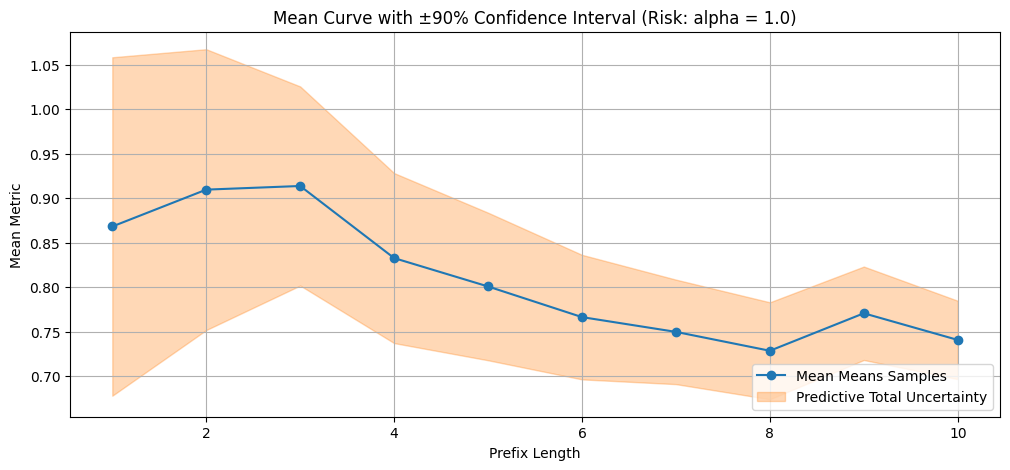

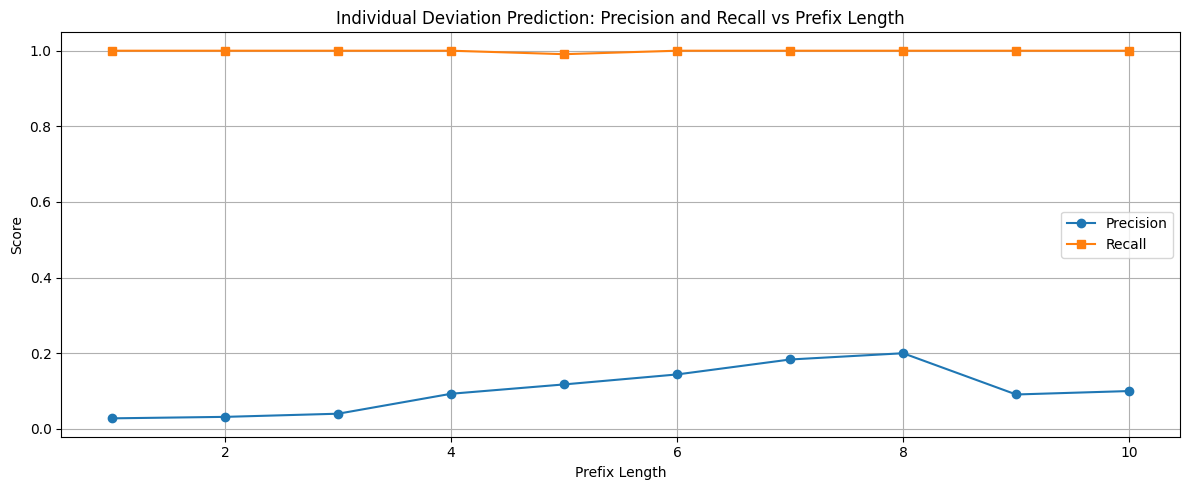

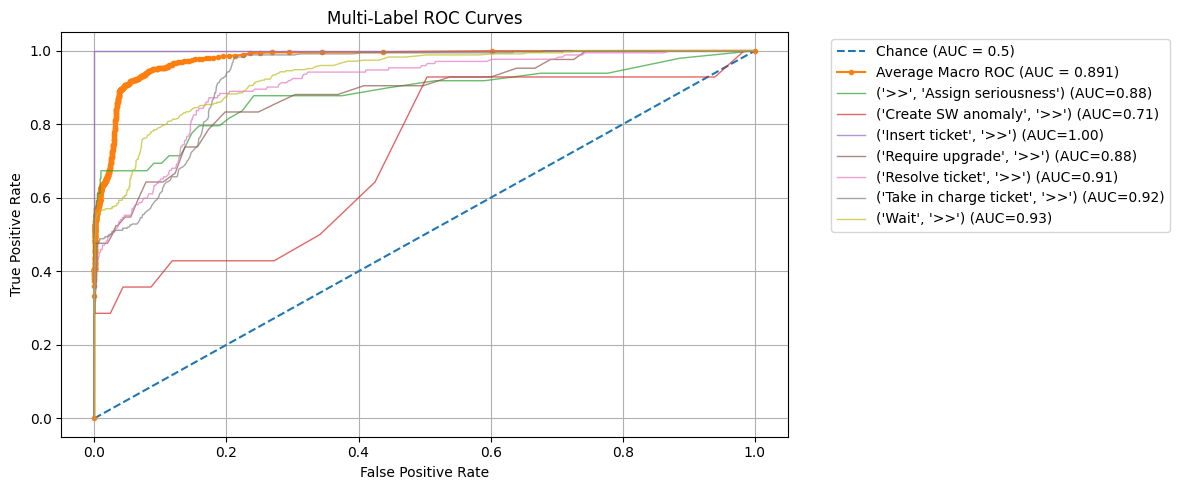

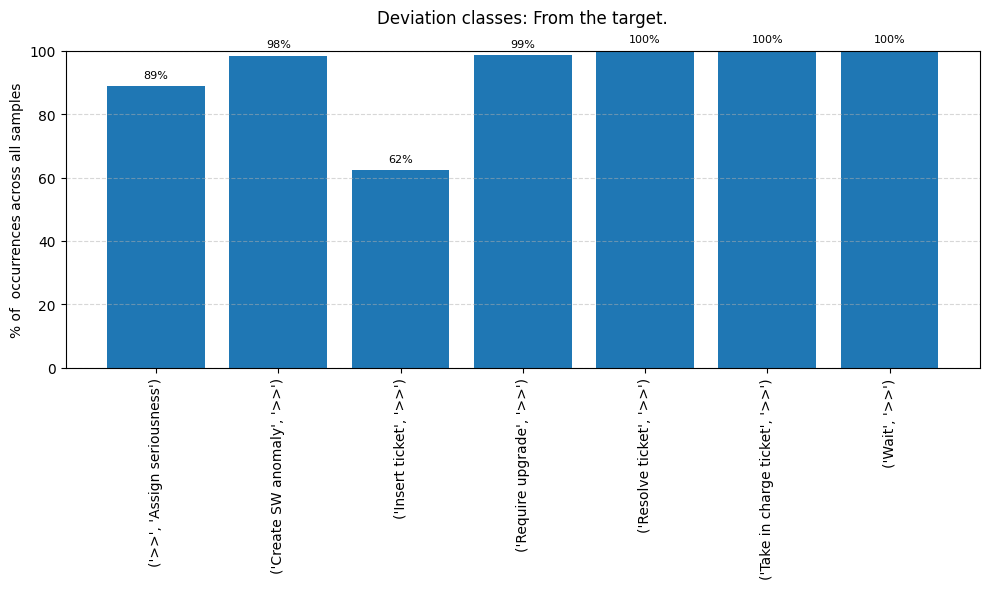

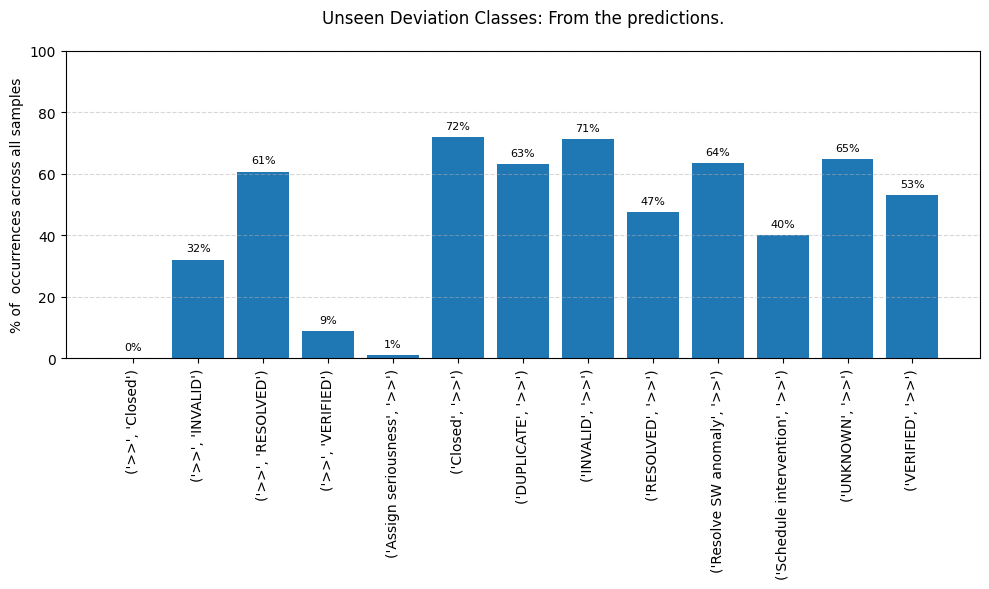

In [31]:
visualize_thresholds_fitness_distribution(result_set=results_all)

visualization_precision_recall(eval_obj=eval_obj_all)

visualization_roc_curve_prob(eval_obj_prob=eval_obj_prob_all)

eval_class_cov = EvaluationMetrics()
visualization_class_coverage(eval_obj=eval_class_cov, target_all=deviations_target_all, target_risk=deviations_samples_all)

In [24]:
deviations_target_low_risk, deviations_most_likely_low_risk, deviations_samples_low_risk, deviations_samples_prob_low_risk = get_idp(result_set=results_low_risk, beta_acceptance_rate=0)

eval_obj_low_risk = EvaluationMetrics(target_alignments=deviations_target_low_risk, predicted_alignments=deviations_samples_low_risk)

eval_obj_prob_low_risk = EvaluationMetrics(target_alignments=deviations_target_low_risk, predicted_alignments=deviations_samples_prob_low_risk)

Thresholds:  [0.88909881 0.93617976 0.96264563 0.8182074  0.83927125 0.73936692
 0.76448889 0.6062421 ]


<Figure size 640x480 with 0 Axes>

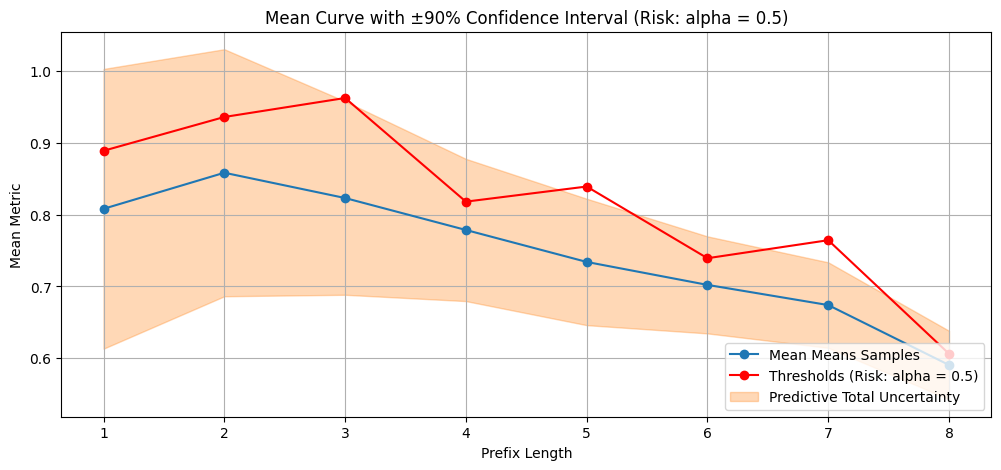

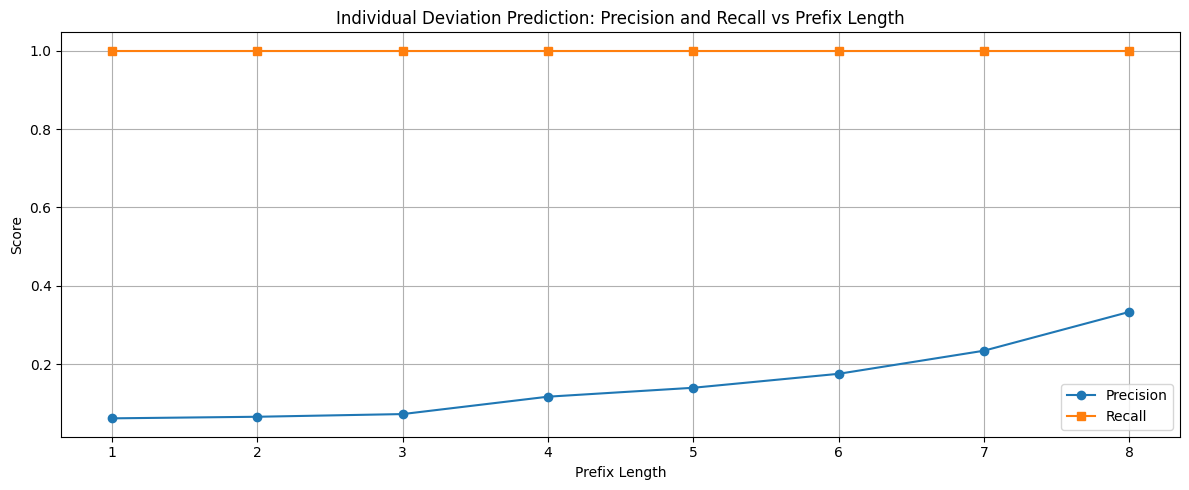

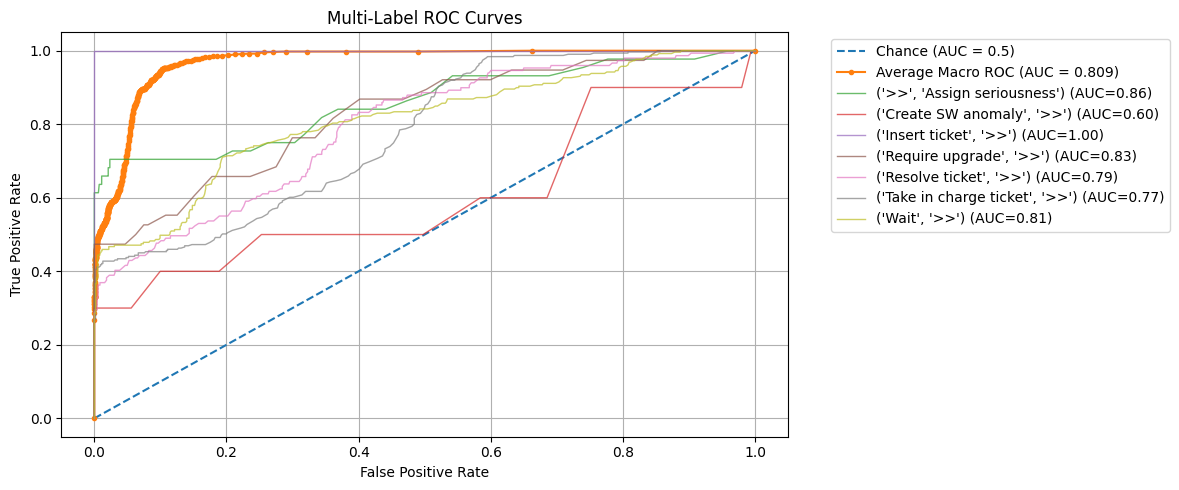

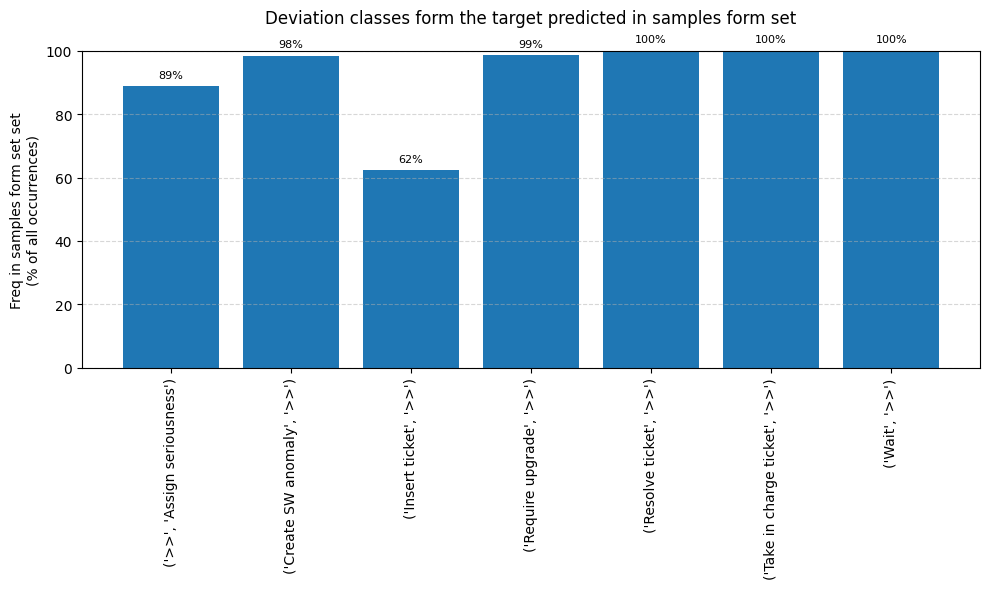

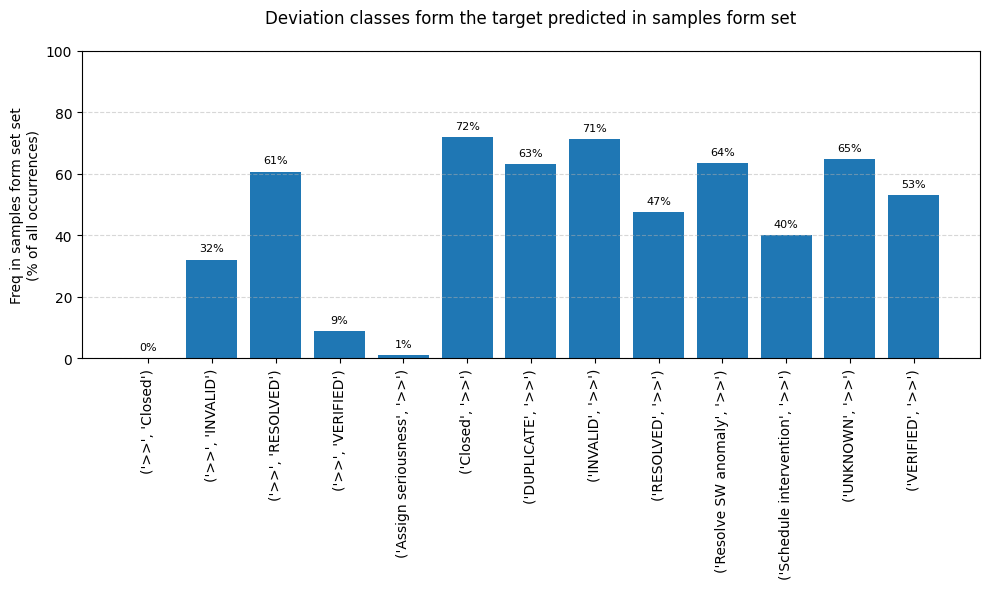

In [28]:
visualize_thresholds_fitness_distribution(result_set=results_low_risk, alpha=alpha_low_risk, thresholds=q_fitness_prefix_lens)

visualization_precision_recall(eval_obj=eval_obj_low_risk)

visualization_roc_curve_prob(eval_obj_prob=eval_obj_prob_low_risk)

eval_class_cov = EvaluationMetrics()
visualization_class_coverage(eval_obj=eval_class_cov, target_all=deviations_target_all, target_risk=deviations_samples_all)

In [14]:
deviations_target_risk, deviations_most_likely_risk, deviations_samples_risk, deviations_samples_prob_risk = get_idp(result_set=results_risk, beta_acceptance_rate=0.25)

eval_obj_risk = EvaluationMetrics(target_alignments=deviations_target_risk, predicted_alignments=deviations_samples_risk)

eval_obj_prob_risk = EvaluationMetrics(target_alignments=deviations_target_risk, predicted_alignments=deviations_samples_prob_risk)

Thresholds:  [0.83698882 0.88317053 0.79140754 0.81392976 0.71465545 0.72188092
 0.65441111 0.6062421 ]


<Figure size 640x480 with 0 Axes>

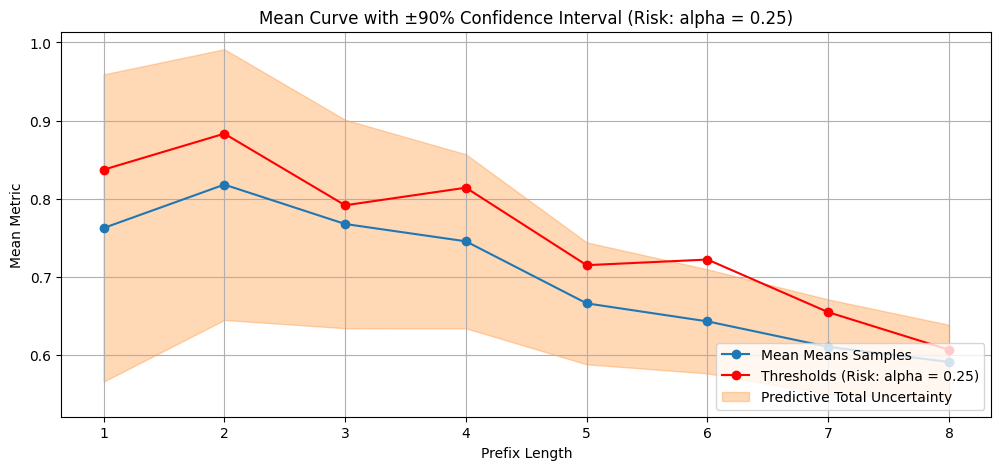

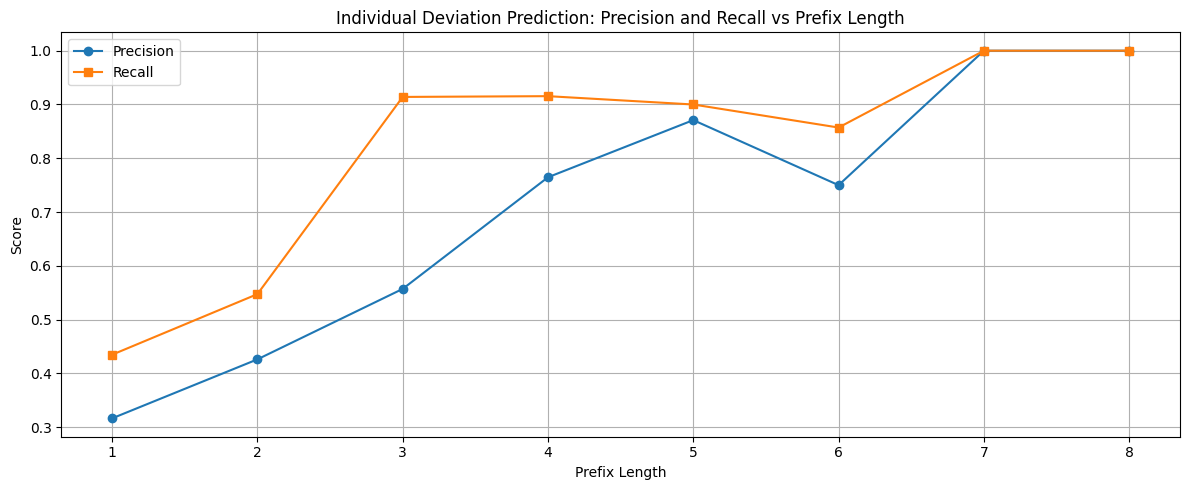

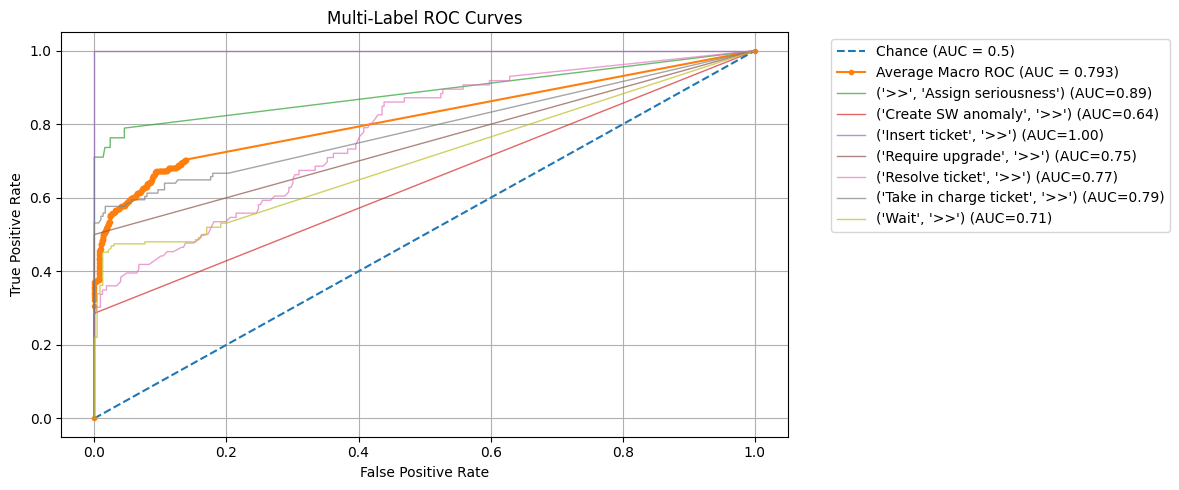

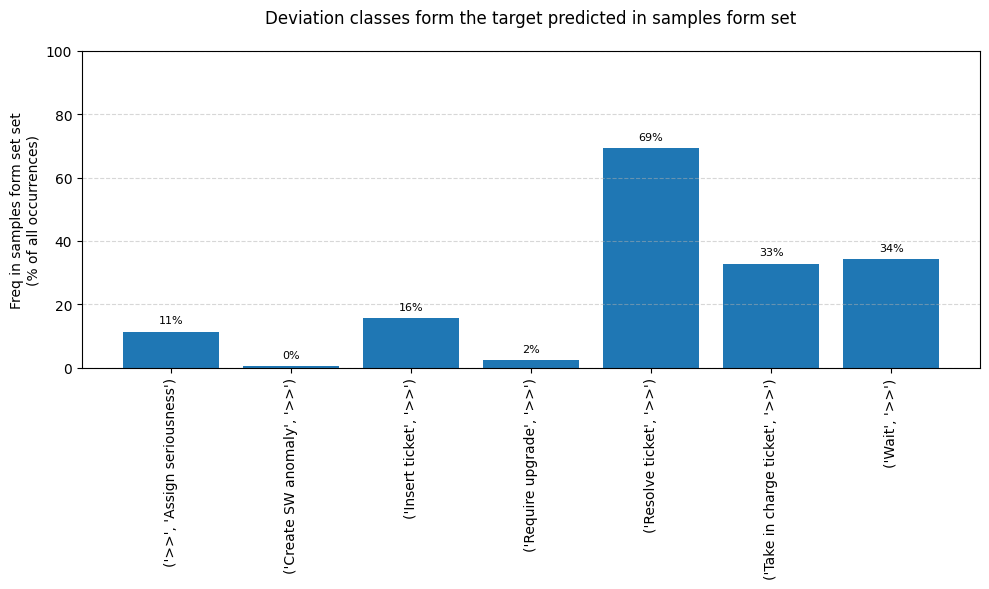

In [22]:
visualize_thresholds_fitness_distribution(result_set=results_risk, alpha=alpha_risk, thresholds=r_fitness_prefix_lens)

visualization_precision_recall(eval_obj=eval_obj_risk)

visualization_roc_curve_prob(eval_obj_prob=eval_obj_prob_risk)

eval_class_cov = EvaluationMetrics()
visualization_class_coverage(eval_obj=eval_class_cov, target_all=deviations_target_all, target_risk=deviations_samples_risk)

In [16]:
deviations_target_high_risk, deviations_most_likely_high_risk, deviations_samples_high_risk, deviations_samples_prob_high_risk = get_idp(result_set=results_high_risk, beta_acceptance_rate=0.25)

eval_obj_high_risk = EvaluationMetrics(target_alignments=deviations_target_high_risk, predicted_alignments=deviations_samples_high_risk)

eval_obj_prob_high_risk = EvaluationMetrics(target_alignments=deviations_target_high_risk, predicted_alignments=deviations_samples_prob_high_risk)

Thresholds:  [0.82582024 0.85006035 0.77066071 0.7304627  0.69786706 0.61379509
 0.65       0.6062421 ]


<Figure size 640x480 with 0 Axes>

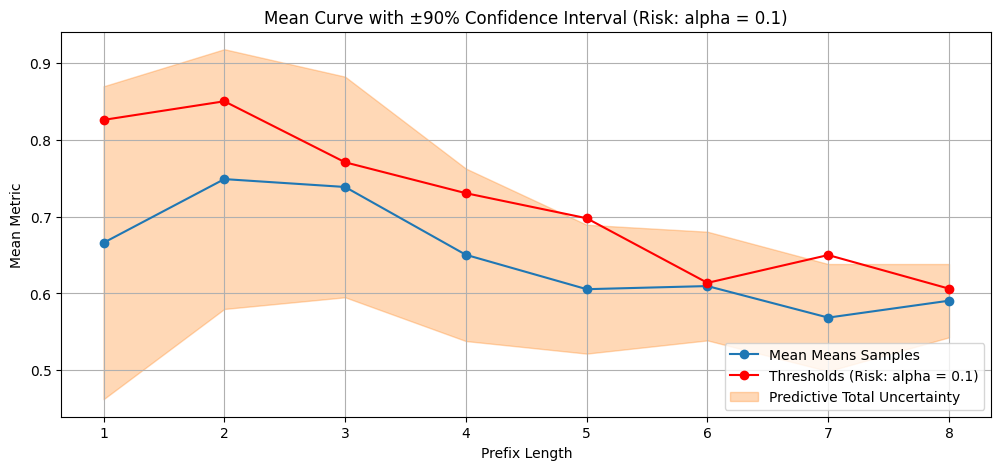

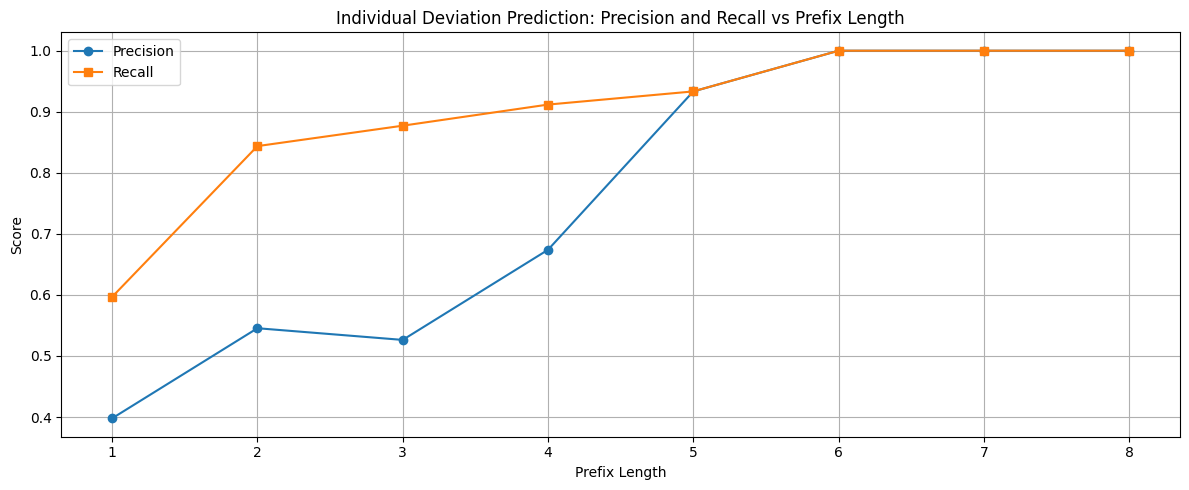

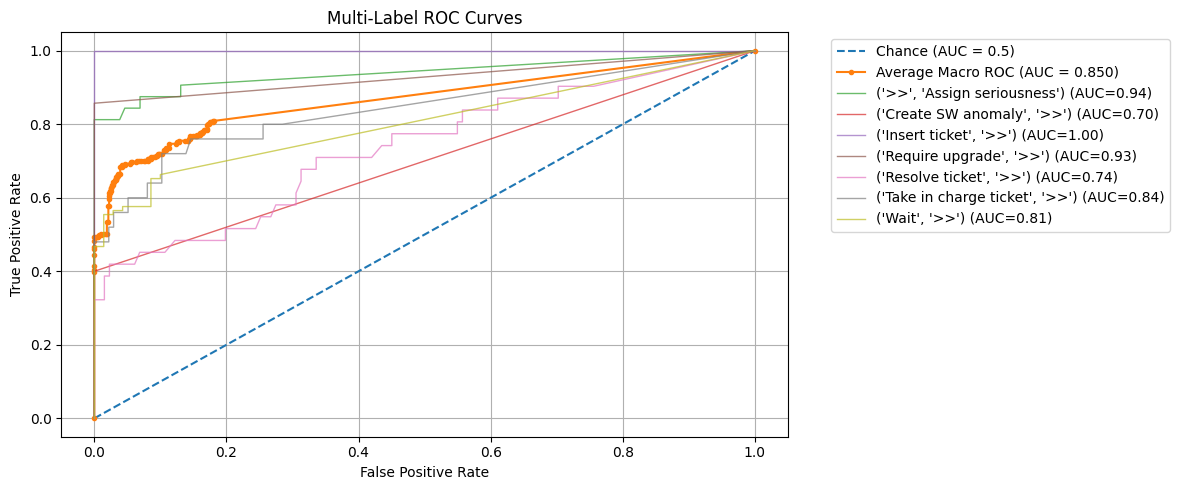

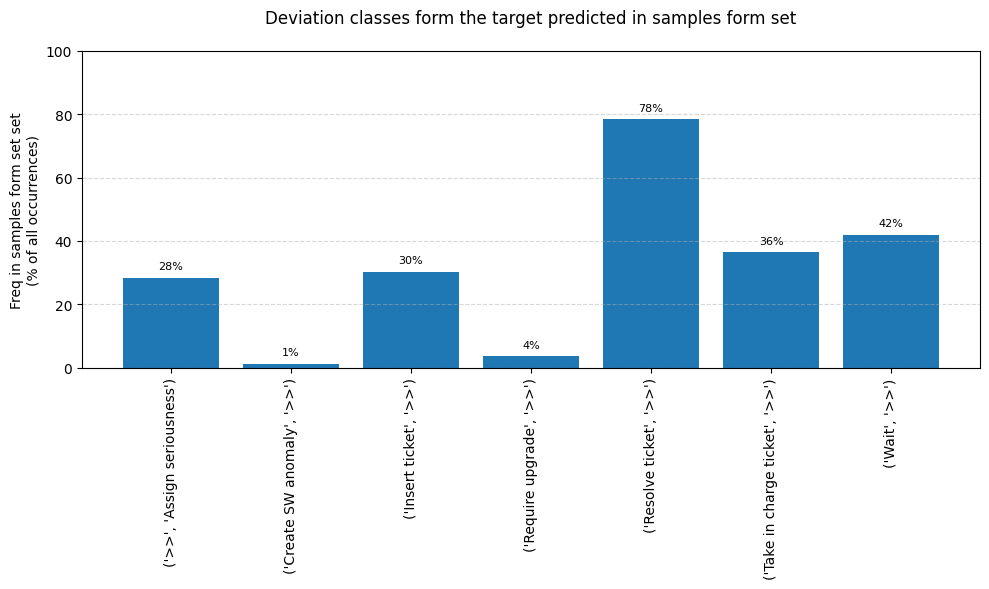

In [23]:
visualize_thresholds_fitness_distribution(result_set=results_high_risk, alpha=alpha_high_risk, thresholds=z_fitness_prefix_lens)

visualization_precision_recall(eval_obj=eval_obj_high_risk)

visualization_roc_curve_prob(eval_obj_prob=eval_obj_prob_high_risk)

eval_class_cov = EvaluationMetrics()
visualization_class_coverage(eval_obj=eval_class_cov, target_all=deviations_target_all, target_risk=deviations_samples_high_risk)